In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gensim
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect("drive/Colab Notebooks/database.sqlite") 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
filtered_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.shape

(525814, 10)

In [8]:
filtered_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [9]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned) 
  return cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))      

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'an', 'herself', 'into', 'mustn', 'through', 'because', 'yours', 'but', 'has', 'so', 'during', 'too', 'isn', 'and', 'same', 'such', 'had', 'myself', 'hadn', "weren't", 'couldn', "you'll", "should've", 'was', 'between', 'of', 'about', 'further', 'do', 'd', 'after', 'themselves', 'which', 'that', "shan't", 'should', "won't", 'all', 'have', "she's", 'she', 'on', 'in', 'aren', 'ourselves', "aren't", 'haven', 'your', 'here', 'been', "mustn't", 'their', "hadn't", 'am', 'theirs', 'where', 'to', 'will', "don't", "you're", 'its', 'now', 'having', 'll', 'are', 'nor', 'we', "didn't", 'some', "you'd", 'above', 'shan', 'hasn', "it's", "needn't", 'then', 'did', "isn't", 'this', 'y', 'if', 'under', 'those', 'with', 'itself', 'any', 'each', 'them', 'it', 'only', "wasn't", 'her', 'he', 'just', 'himself', 're', 'against', 'there', 'him', 'my', 'other', 'before', 'our', 'be', 'ma', 'were', 'or'

In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Time based splitting

In [0]:
import datetime

In [0]:
final['Time']=final['Time'].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

In [14]:
final["Time"].head()

138706    1999-10-08 00:00:00
138688    2007-11-11 00:00:00
138689    2007-10-04 00:00:00
138690    2004-02-06 00:00:00
138691    2002-04-10 00:00:00
Name: Time, dtype: object

In [0]:
final=final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
final_sample=final['CleanedText'].values[0:100000]
final_score=final['Score'].values[0:100000]

In [19]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


# ALL LOGISTIC REGRESSION FUNCTION

In [0]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

def LogisticRwithL2(X_train,Y_train,X_test,Y_test,C_optimum):
  lr =LogisticRegression(C=C_optimum,penalty='l2')
  lr.fit(X_train,Y_train)
  pred = lr.predict(X_test)
  print(' accuracy with C =',C_optimum,' is ' ,np.round((accuracy_score(Y_test, pred)*100),decimals = 2))
  print('F1 score with C =',C_optimum,' is ' , np.round((f1_score(Y_test, pred,average= 'macro')*100),decimals = 2))
  print('Recall with C =',C_optimum,' is ' , np.round((recall_score(Y_test, pred,average= 'macro')*100),decimals = 2))
  print('Precision with C =',C_optimum,' is ' , np.round((precision_score(Y_test, pred,average= 'macro')*100),decimals = 2))
  print ('\n Classification report  with C =',C_optimum,' is \n ' , classification_report(Y_test,pred)) 
  print('no. of non zero elements =',np.count_nonzero(lr.coef_))

In [0]:
def LogisticRwithL1(X_train,Y_train,X_test,Y_test,C_optimum):
  lr =LogisticRegression(C=C_optimum,penalty='l1')
  lr.fit(X_train,Y_train)
  pred = lr.predict(X_test)
  print(' accuracy with C =',C_optimum,' is ' ,np.round((accuracy_score(Y_test, pred)*100),decimals = 2))
  print('F1 score with C =',C_optimum,' is ' , np.round((f1_score(Y_test, pred,average= 'macro')*100),decimals = 2))
  print('Recall with C =',C_optimum,' is ' , np.round((recall_score(Y_test, pred,average= 'macro')*100),decimals = 2))
  print('Precision with C =',C_optimum,' is ' , np.round((precision_score(Y_test, pred,average= 'macro')*100),decimals = 2))
  print ('\n Classification report  with C =',C_optimum,' is \n ' , classification_report(Y_test,pred)) 
  print('no. of non zero elements =',np.count_nonzero(lr.coef_))

# GRID SEARCH CV FOR LAMBDA

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
def bestLambda(X_train,Y_train,X_test,Y_test):
  lr = LogisticRegression()
  param_grid={'C':np.arange(1,50,2),'penalty':['l1','l2']}
  gsv = GridSearchCV(lr,param_grid,verbose=1)
  gsv.fit(X_train,Y_train)
  C_optimum=gsv.best_params_
  return C_optimum
    

# RANDOM SEARCH CV

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
def bestLambdaR(X_train,Y_train,X_test,Y_test):
  lr = LogisticRegression()
  param_grid={'C':np.arange(1,50,2),'penalty':['l1','l2']}
  rsv = RandomizedSearchCV(lr,param_grid,verbose=1)
  rsv.fit(X_train,Y_train)
  C_optimum=rsv.best_params_
  return C_optimum
    

# FUNCTION TO SHOW MOST IMPORTANT FEATURES

In [0]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# Bag Of Words

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_sample,final_score,test_size=0.3,shuffle=False)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,1))
Vocabulary = count_vect.fit_transform(X_train)



In [0]:
bow_X_train=count_vect.transform(X_train)
bow_X_test=count_vect.transform(X_test)

In [0]:
from sklearn import preprocessing 
bow_X_train= preprocessing.normalize(bow_X_train)
bow_X_test = preprocessing.normalize(bow_X_test)


In [67]:
BestHyperparameter = bestLambda(bow_X_train,Y_train,bow_X_test,Y_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.8min finished


In [68]:
BestHyperparameterR = bestLambdaR(bow_X_train,Y_train,bow_X_test,Y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


In [69]:
print("BEST HYPERPARAMETER WITH GRID SEARCH",BestHyperparameter)

BEST HYPERPARAMETER WITH GRID SEARCH {'C': 5, 'penalty': 'l2'}


In [70]:
print("BEST HYPERPARAMETER WITH RANDOM SEARCH",BestHyperparameterR)

BEST HYPERPARAMETER WITH RANDOM SEARCH {'penalty': 'l2', 'C': 5}


# Logistic Regression with  L2 regularizer 

In [34]:
LogisticRwithL2(bow_X_train,Y_train,bow_X_test,Y_test,5)

 accuracy with C = 5  is  92.34
F1 score with C = 5  is  81.66
Recall with C = 5  is  78.14
Precision with C = 5  is  86.89

 Classification report  with C = 5  is 
               precision    recall  f1-score   support

   negative       0.80      0.59      0.68      4103
   positive       0.94      0.98      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 31373



# Confusion matrix for L2 regularization


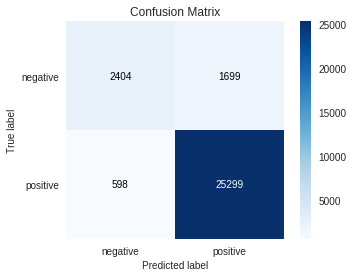

In [39]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=5,penalty='l2')
lr.fit(bow_X_train,Y_train)
pred = lr.predict(bow_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# L1 REGULARIZER

In [41]:
LogisticRwithL1(bow_X_train,Y_train,bow_X_test,Y_test,5)

 accuracy with C = 5  is  92.36
F1 score with C = 5  is  82.22
Recall with C = 5  is  79.42
Precision with C = 5  is  86.0

 Classification report  with C = 5  is 
               precision    recall  f1-score   support

   negative       0.78      0.62      0.69      4103
   positive       0.94      0.97      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 3235


# Confusion matrix for L1 regularization


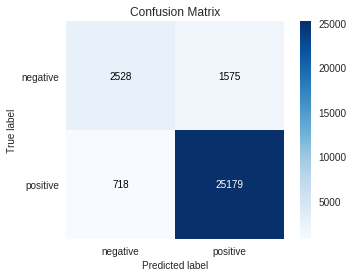

In [40]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=5,penalty='l1')
lr.fit(bow_X_train,Y_train)
pred = lr.predict(bow_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# sparcity check with respect to c

In [63]:
LogisticRwithL1(bow_X_train,Y_train,bow_X_test,Y_test,5)

 accuracy with C = 5  is  92.49
F1 score with C = 5  is  79.61
Recall with C = 5  is  76.18
Precision with C = 5  is  84.66

 Classification report  with C = 5  is 
               precision    recall  f1-score   support

   negative       0.75      0.55      0.63      1781
   positive       0.94      0.98      0.96     13219

avg / total       0.92      0.92      0.92     15000

no. of non zero elements = 2118


In [64]:
LogisticRwithL1(bow_X_train,Y_train,bow_X_test,Y_test,3)

 accuracy with C = 3  is  92.71
F1 score with C = 3  is  79.7
Recall with C = 3  is  75.68
Precision with C = 3  is  86.15

 Classification report  with C = 3  is 
               precision    recall  f1-score   support

   negative       0.78      0.53      0.63      1781
   positive       0.94      0.98      0.96     13219

avg / total       0.92      0.93      0.92     15000

no. of non zero elements = 1472


In [65]:
LogisticRwithL1(bow_X_train,Y_train,bow_X_test,Y_test,1)

 accuracy with C = 1  is  92.15
F1 score with C = 1  is  76.74
Recall with C = 1  is  71.86
Precision with C = 1  is  86.5

 Classification report  with C = 1  is 
               precision    recall  f1-score   support

   negative       0.80      0.45      0.58      1781
   positive       0.93      0.98      0.96     13219

avg / total       0.91      0.92      0.91     15000

no. of non zero elements = 625


In [0]:
!pip install scikit-plot

**AS YOU CAN SEE THAT WITH decrease IN  'C ' the sparcity increases that is no. of non-zero weight vectors decreases '**

# PERTUBATION TEST on Unigram

In [110]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression(C=20,penalty='l2')
lr.fit(bow_X_train,Y_train)


print(lr.coef_[0])

[0.00143909 0.08824252 0.16705688 ... 0.12037403 0.00196327 0.01837989]


In [111]:
weights= lr.coef_[0]
weights = weights[0:50]
print(weights)
print("No. of non zero elements",np.count_nonzero(lr.coef_[0]))

[ 1.43909353e-03  8.82425182e-02  1.67056878e-01  1.42181368e-03
  7.93687318e-03  1.37589299e-01 -7.86192362e-01  8.79456880e-04
  2.04082402e-03 -2.48066296e-01  5.40205472e-01  4.51962222e-01
  3.22147298e-02  1.48241759e-02  1.14899889e+00  4.86195978e-03
  1.76709022e+00 -1.86712404e+00  2.17497418e-02  1.00648211e-01
  7.57382107e-02  6.42400099e-02  4.20685186e-01  6.40698425e-02
 -4.98103277e-01  9.67400445e-02  7.33078726e-03 -8.00948187e-02
  1.55037059e+00  2.45315028e-02  1.33082458e-02  4.83233961e-03
  7.81995558e-02  2.08179453e-01 -3.38873552e-02  4.73003071e-04
  8.48514723e-01  2.99383169e-02  3.58341721e+00 -2.21040081e+00
  6.00613468e-04  5.01573148e-02  1.39973658e+00  1.07491484e+00
 -9.77751646e-01  7.39365295e-02  1.80685975e-01  2.30281418e-03
  1.94078430e-01  5.08287018e-02]
No. of non zero elements 31373


In [0]:
from scipy.sparse import find
bow_X_trainE=bow_X_train
epsilon = np.random.uniform(low=-0.0001,high=0.0001,size=(find(bow_X_trainE)[0].size,))
a,b,c=find(bow_X_trainE)
bow_X_trainE[a,b] = epsilon + bow_X_trainE[a,b]

In [113]:
from sklearn.linear_model import LogisticRegression
lr1 =  LogisticRegression(C=20,penalty='l2')
lr1.fit(bow_X_trainE,Y_train)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
weights2=lr1.coef_[0]
weights2=weights2[:50]

In [115]:
weights2

array([ 1.43449031e-03,  8.83314745e-02,  1.66718987e-01,  1.41689769e-03,
        7.95406965e-03,  1.37165579e-01, -7.85154850e-01,  8.77469825e-04,
        2.03747039e-03, -2.47859048e-01,  5.40100831e-01,  4.51081429e-01,
        3.20885665e-02,  1.48355209e-02,  1.14759092e+00,  4.85574425e-03,
        1.76530152e+00, -1.86421952e+00,  2.17395354e-02,  1.00685198e-01,
        7.56721362e-02,  6.41340145e-02,  4.20495277e-01,  6.40150524e-02,
       -4.96566766e-01,  9.65406169e-02,  7.32628999e-03, -8.02103179e-02,
        1.54705350e+00,  2.45246947e-02,  1.32938976e-02,  4.81801346e-03,
        7.81940460e-02,  2.08168385e-01, -3.38016959e-02,  4.74997404e-04,
        8.48005601e-01,  2.99937644e-02,  3.58088653e+00, -2.20818994e+00,
        5.98943575e-04,  5.00609517e-02,  1.39733590e+00,  1.07162488e+00,
       -9.76836300e-01,  7.37373214e-02,  1.81030434e-01,  2.30083293e-03,
        1.93866258e-01,  5.08421596e-02])

In [0]:
difference = (abs(weights - weights2)/weights)*100

In [118]:
print(difference[np.where(difference > 30)].size)

0


# Multicollinearity do not exist as there are no features which changes by 30% after perbutation test

In [0]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [74]:
show_most_informative_features(count_vect, lr, n=20)

	-14.1087	worst          		9.2031	perfect        
	-9.6417	terribl        		8.5036	delici         
	-9.0449	aw             		8.2335	excel          
	-8.6445	bland          		7.9230	amaz           
	-8.4120	disappoint     		7.5952	best           
	-8.0676	horribl        		7.4570	addict         
	-8.0636	threw          		6.9412	great          
	-7.7762	tasteless      		6.7050	awesom         
	-7.3008	stale          		6.6122	uniqu          
	-7.2922	wors           		6.5183	yummi          
	-7.1808	unfortun       		6.4361	fantast        
	-7.0251	gross          		6.1657	smooth         
	-6.9101	unpleas        		5.8967	beat           
	-6.8593	disgust        		5.7302	hook           
	-6.7550	return         		5.6699	nice           
	-6.6985	weak           		5.6653	often          
	-6.4713	yuck           		5.5333	refresh        
	-6.3496	sorri          		5.4849	skeptic        
	-6.1382	lack           		5.3707	wonder         
	-6.1141	stuck          		5.3327	beauti         


# BI-gram

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_sample,final_score,test_size=0.3,shuffle=False)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,2))
Vocabulary = count_vect.fit_transform(X_train)



In [0]:
bow2_X_train=count_vect.transform(X_train)
bow2_X_test=count_vect.transform(X_test)

In [0]:
from sklearn import preprocessing 
bow2_X_train= preprocessing.normalize(bow2_X_train)
bow2_X_test = preprocessing.normalize(bow2_X_test)


In [48]:
BestHyperparameter = bestLambda(bow2_X_train,Y_train,bow2_X_test,Y_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 22.7min finished


In [49]:
print(BestHyperparameter)

{'C': 27, 'penalty': 'l2'}


In [50]:
BestHyperparameterR = bestLambdaR(bow2_X_train,Y_train,bow2_X_test,Y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.0min finished


In [51]:
print(BestHyperparameterR)

{'penalty': 'l2', 'C': 27}


# Logistic Regression with L2 regularizer

In [52]:
LogisticRwithL2(bow2_X_train,Y_train,bow2_X_test,Y_test,27)

 accuracy with C = 27  is  93.08
F1 score with C = 27  is  83.74
Recall with C = 27  is  80.49
Precision with C = 27  is  88.26

 Classification report  with C = 27  is 
               precision    recall  f1-score   support

   negative       0.82      0.63      0.71      4103
   positive       0.94      0.98      0.96     25897

avg / total       0.93      0.93      0.93     30000

no. of non zero elements = 918966


# Confusion matrix for L2 regularizer

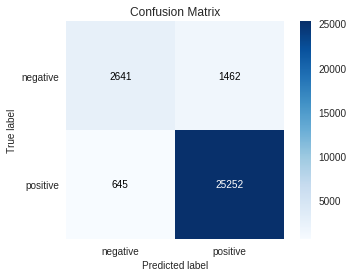

In [53]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=27,penalty='l2')
lr.fit(bow_X_train,Y_train)
pred = lr.predict(bow_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# Logistic Regression with L1 regularizer

In [54]:
LogisticRwithL1(bow2_X_train,Y_train,bow2_X_test,Y_test,27)

 accuracy with C = 27  is  92.38
F1 score with C = 27  is  83.03
Recall with C = 27  is  81.44
Precision with C = 27  is  84.9

 Classification report  with C = 27  is 
               precision    recall  f1-score   support

   negative       0.75      0.66      0.70      4103
   positive       0.95      0.96      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 10653


# * Confusion matrix for L1 regularizer*

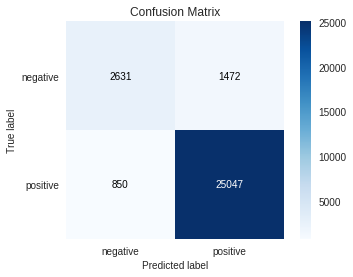

In [55]:
import scikitplot.metrics as skplt

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=27,penalty='l1')
lr.fit(bow_X_train,Y_train)
pred = lr.predict(bow_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# SPARCITY CHECK WITH DECREASE IN C

In [56]:
LogisticRwithL1(bow2_X_train,Y_train,bow2_X_test,Y_test,27)

 accuracy with C = 27  is  92.37
F1 score with C = 27  is  83.02
Recall with C = 27  is  81.42
Precision with C = 27  is  84.89

 Classification report  with C = 27  is 
               precision    recall  f1-score   support

   negative       0.75      0.66      0.70      4103
   positive       0.95      0.96      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 10657


In [57]:
LogisticRwithL1(bow2_X_train,Y_train,bow2_X_test,Y_test,23)

 accuracy with C = 23  is  92.4
F1 score with C = 23  is  83.07
Recall with C = 23  is  81.46
Precision with C = 23  is  84.97

 Classification report  with C = 23  is 
               precision    recall  f1-score   support

   negative       0.75      0.66      0.71      4103
   positive       0.95      0.97      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 10373


In [58]:
LogisticRwithL1(bow2_X_train,Y_train,bow2_X_test,Y_test,20)

 accuracy with C = 20  is  92.44
F1 score with C = 20  is  83.13
Recall with C = 20  is  81.47
Precision with C = 20  is  85.08

 Classification report  with C = 20  is 
               precision    recall  f1-score   support

   negative       0.75      0.66      0.71      4103
   positive       0.95      0.97      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 10075


In [59]:
LogisticRwithL1(bow2_X_train,Y_train,bow2_X_test,Y_test,15)

 accuracy with C = 15  is  92.51
F1 score with C = 15  is  83.24
Recall with C = 15  is  81.48
Precision with C = 15  is  85.34

 Classification report  with C = 15  is 
               precision    recall  f1-score   support

   negative       0.76      0.66      0.71      4103
   positive       0.95      0.97      0.96     25897

avg / total       0.92      0.93      0.92     30000

no. of non zero elements = 9363


## WE CAN SEE THAT SPARCITY INCREASE WITH DECREASE IN C

# Perbutation test

In [118]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression(C=27,penalty='l2')
lr.fit(bow2_X_train,Y_train)


print(lr.coef_[0])

[0.00183091 0.00183091 0.03608785 ... 0.00170762 0.00170762 0.01202043]


In [119]:
weights= lr.coef_[0]
weights = weights[0:50]
print(weights)
print("No. of non zero elements",np.count_nonzero(lr.coef_[0]))

[ 1.83090960e-03  1.83090960e-03  3.60878489e-02  3.22363365e-02
  1.18948941e-02  2.03414424e-02  5.24986946e-03  5.24986946e-03
  3.53918743e-03  3.53918743e-03  4.35763379e-02  1.05480501e-02
  4.21456720e-04  3.26068311e-02 -2.97079247e-01 -2.97079247e-01
  4.48427393e-04  4.48427393e-04  2.58184407e-03 -1.49875329e-01
 -1.53613327e-01  2.04049831e-03  1.69749973e-03  1.54930614e-01
  1.54930614e-01  2.42271792e-01  2.42271792e-01  1.98872815e-03
  1.98872815e-03  5.30925472e-03  5.30925472e-03  4.28800116e-01
  4.28800116e-01  1.03818215e-03  9.58019975e-04  7.68256935e-01
  9.20945015e-04  3.75375237e-03  1.90558743e-01 -4.17239750e-01
  5.73472528e-03  4.71554208e-02  8.53821224e-01  8.35518734e-02
 -6.42244473e-01  4.98207689e-02  2.49467352e-02  4.04769647e-03
  8.83734542e-04  1.01336915e-02]
No. of non zero elements 918966


In [0]:
from scipy.sparse import find
bow2_X_trainE=bow2_X_train
epsilon = np.random.uniform(low=0.0,high=0.01,size=(find(bow_X_trainE)[0].size))
a,b,c=find(bow_X_trainE)
bow2_X_trainE[a,b] = epsilon + bow2_X_trainE[a,b]

In [121]:
from sklearn.linear_model import LogisticRegression
lr1 =  LogisticRegression(C=27,penalty='l2')
lr1.fit(bow2_X_trainE,Y_train)

LogisticRegression(C=27, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
weights2=lr1.coef_[0]
weights2=weights2[:50]

In [0]:
difference = (abs(weights - weights2)/weights)*100

In [124]:
print(difference[np.where(difference >30)].size)

2265


# MULTICOLLINEARITY EXIST AS THERE ARE 2265 features which are changing by more than 30%

# IMPORTANT FEATURES IN BIGRAM

In [111]:
show_most_informative_features(count_vect, lr, n=20)

	-21.0157	worst          		14.2549	high recommend 
	-15.0177	terribl        		13.1209	perfect        
	-14.4289	disappoint     		12.3832	delici         
	-13.4257	bland          		11.8469	excel          
	-13.2752	aw             		11.6151	amaz           
	-12.7544	threw          		10.8764	best           
	-12.2399	horribl        		10.6961	addict         
	-12.2268	two star       		10.0024	fantast        
	-11.4454	wont buy       		9.9921	wont disappoint
	-11.3727	tasteless      		9.9474	yummi          
	-11.2003	unfortun       		9.5136	awesom         
	-11.0541	stale          		9.3808	great          
	-10.8979	wors           		8.9843	uniqu          
	-10.7411	weak           		8.9582	often          
	-10.5170	disgust        		8.7430	smooth         
	-10.3372	gross          		8.5913	hook           
	-10.2419	way sweet      		8.2775	nice           
	-10.2389	return         		8.0306	moist          
	-10.0163	sorri          		8.0236	wonder         
	-9.8548	unpleas        		7.9777	beat     

# TF_IDF

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_sample,final_score,test_size=0.3,shuffle=False)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
Vocabulary = tfidf_vect.fit_transform(X_train)


In [0]:
tfidf_X_train=tfidf_vect.transform(X_train)
tfidf_X_test=tfidf_vect.transform(X_test)

In [0]:
from sklearn import preprocessing 
tfidf_X_train= preprocessing.normalize(tfidf_X_train)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)

# GRID SEARCH CV

In [27]:
BestHyperparameter = bestLambda(tfidf_X_train,Y_train,tfidf_X_test,Y_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 14.3min finished


In [28]:
print(BestHyperparameter)

{'C': 3, 'penalty': 'l1'}


# RANDOM SEARCH CV

In [29]:
BestHyperparameterR = bestLambdaR(tfidf_X_train,Y_train,tfidf_X_test,Y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.1min finished


In [30]:
print(BestHyperparameterR)

{'penalty': 'l1', 'C': 7}


# LOGISTIC REGRESSION WITH L2 REGULARIZER

In [31]:
LogisticRwithL2(tfidf_X_train,Y_train,tfidf_X_test,Y_test,3)

 accuracy with C = 3  is  92.49
F1 score with C = 3  is  81.0
Recall with C = 3  is  76.22
Precision with C = 3  is  89.57

 Classification report  with C = 3  is 
               precision    recall  f1-score   support

   negative       0.86      0.54      0.66      4103
   positive       0.93      0.99      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 918966


In [32]:
LogisticRwithL2(tfidf_X_train,Y_train,tfidf_X_test,Y_test,7)

 accuracy with C = 7  is  92.87
F1 score with C = 7  is  82.46
Recall with C = 7  is  78.14
Precision with C = 7  is  89.48

 Classification report  with C = 7  is 
               precision    recall  f1-score   support

   negative       0.85      0.58      0.69      4103
   positive       0.94      0.98      0.96     25897

avg / total       0.93      0.93      0.92     30000

no. of non zero elements = 918966


# CONFUSION MATRIX FOR L2 regularizer

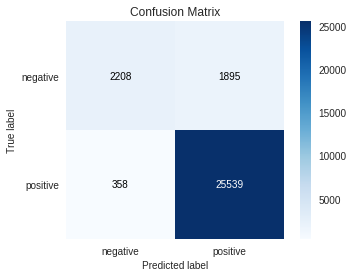

In [35]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=3,penalty='l2')
lr.fit(tfidf_X_train,Y_train)
pred = lr.predict(tfidf_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# CONFUSION MATRIX FOR L1 regularizer

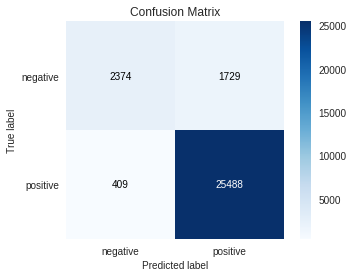

In [36]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=7,penalty='l1')
lr.fit(tfidf_X_train,Y_train)
pred = lr.predict(tfidf_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# SPARCITY CHECK WITH DECREASE IN C

In [113]:
LogisticRwithL1(tfidf_X_train,Y_train,tfidf_X_test,Y_test,7)

 accuracy with C = 7  is  91.89
F1 score with C = 7  is  81.43
Recall with C = 7  is  79.12
Precision with C = 7  is  84.4

 Classification report  with C = 7  is 
               precision    recall  f1-score   support

   negative       0.75      0.62      0.67      4103
   positive       0.94      0.97      0.95     25897

avg / total       0.91      0.92      0.92     30000

no. of non zero elements = 5781


In [114]:
LogisticRwithL1(tfidf_X_train,Y_train,tfidf_X_test,Y_test,6)

 accuracy with C = 6  is  92.07
F1 score with C = 6  is  81.74
Recall with C = 6  is  79.26
Precision with C = 6  is  84.99

 Classification report  with C = 6  is 
               precision    recall  f1-score   support

   negative       0.76      0.62      0.68      4103
   positive       0.94      0.97      0.95     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 5330


In [115]:
LogisticRwithL1(tfidf_X_train,Y_train,tfidf_X_test,Y_test,4)

 accuracy with C = 4  is  92.22
F1 score with C = 4  is  81.89
Recall with C = 4  is  79.1
Precision with C = 4  is  85.65

 Classification report  with C = 4  is 
               precision    recall  f1-score   support

   negative       0.77      0.61      0.68      4103
   positive       0.94      0.97      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 4129


In [116]:
LogisticRwithL1(tfidf_X_train,Y_train,tfidf_X_test,Y_test,2)

 accuracy with C = 2  is  92.36
F1 score with C = 2  is  81.86
Recall with C = 2  is  78.52
Precision with C = 2  is  86.68

 Classification report  with C = 2  is 
               precision    recall  f1-score   support

   negative       0.80      0.59      0.68      4103
   positive       0.94      0.98      0.96     25897

avg / total       0.92      0.92      0.92     30000

no. of non zero elements = 2295


# AS YOU CAN SEE THAT SPARCITY INCREASE WITH DECREASE IN C

# PERTUBATION TEST

In [125]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression(C=27,penalty='l2')
lr.fit(tfidf_X_train,Y_train)
print('*********************************')

print(lr.coef_[0])
weights= lr.coef_[0]
weights = weights[0:50]
print(weights)
print("No. of non zero elements",np.count_nonzero(lr.coef_[0]))
print('*********************************')

from scipy.sparse import find
tfidf_X_trainE=bow_X_train
epsilon = np.random.uniform(low=0.0,high=0.01,size=(find(tfidf_X_trainE)[0].size))
a,b,c=find(tfidf_X_trainE)
tfidf_X_trainE[a,b] = epsilon + tfidf_X_trainE[a,b]
print('*********************************')

from sklearn.linear_model import LogisticRegression
lr1 =  LogisticRegression(C=27,penalty='l2')
lr1.fit(tfidf_X_trainE,Y_train)
print('*********************************')

weights2=lr1.coef_[0]
weights2=weights2[:50]
print('*********************************')

difference = (abs(weights - weights2)/weights)*100
print('*********************************')

print(difference[np.where(difference >30)].size)


*********************************
[0.00089384 0.14481999 0.28364785 ... 0.32396168 0.00299528 0.0640836 ]
[ 8.93842900e-04  1.44819988e-01  2.83647853e-01  2.95488130e-03
  2.07885411e-02  3.48426534e-01 -1.24010528e+00  2.02337062e-03
  1.78175250e-02 -3.76851123e-01  7.67005032e-01  5.47187561e-01
  9.15281132e-02  6.07691082e-02  2.26540942e+00  7.20566757e-03
  2.36371393e+00 -2.80181760e+00  3.16220030e-02  1.74576616e-01
  2.44879085e-01  1.49016309e-01  6.39610452e-01  2.51924115e-01
 -4.43837155e-01  1.73459587e-01  3.08024740e-02 -3.33419541e-01
  2.35134455e+00  1.02405684e-01  7.21961743e-02  1.11286373e-02
  1.59572669e-01  2.56513070e-01 -3.57054347e-02  1.99428191e-03
  1.31585437e+00  9.76708468e-02  3.50730918e+00 -2.75198808e+00
  1.81050513e-03  9.18772623e-02  1.93227102e+00  1.36208306e+00
 -1.59118752e+00  2.55048840e-01  3.02719164e-01  7.27463106e-03
  4.11521171e-01  8.88531764e-02]
No. of non zero elements 31373
*********************************
***************

# multicollinearity exists as there are 1016 features with change of more than 30%

# Important features


In [126]:
show_most_informative_features(tfidf_vect, lr, n=20)

	-18.8331	worst          		15.4645	great          
	-10.4459	disappoint     		14.1505	perfect        
	-10.4261	ugh            		14.1266	best           
	-10.2882	fragment       		12.7611	delici         
	-10.1322	terribl        		11.2608	love           
	-9.9755	aw             		11.0916	amaz           
	-9.7005	thamk          		11.0642	addict         
	-8.9574	threw          		10.9527	skeptic        
	-8.9480	flavorless     		10.8526	excel          
	-8.9217	yadayadayada   		10.0002	awesom         
	-8.8950	unaccept       		9.3719	accur          
	-8.8721	bland          		9.3575	downsid        
	-8.7850	unfortun       		9.1729	yummi          
	-8.7196	blech          		9.1229	uniqu          
	-8.6331	horribl        		8.8465	smooth         
	-8.5939	compass        		8.7413	yum            
	-8.5809	hsve           		8.6995	nice           
	-8.5123	ripoff         		8.6938	fantast        
	-8.4943	simmilar       		8.6882	hook           
	-8.4409	useless        		8.6573	often          


# AVG WORD 2 vec

In [0]:
list_of_sent[1]

In [0]:
i=0
str1=''
list_of_sent=[]
final_string_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (words.lower() not in stop)):    
                filtered_sentence.append(words.lower())
                str1 += " "+words.lower() 
            else:
                continue
   
    list_of_sent.append(filtered_sentence)
    final_string_tfidf.append((str1).strip())

In [0]:
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [26]:
w2v_model.most_similar("like")

[('weird', 0.7607990503311157),
 ('okay', 0.7277082204818726),
 ('ok', 0.719261646270752),
 ('either', 0.6932376623153687),
 ('kind', 0.6884601712226868),
 ('good', 0.686037003993988),
 ('gross', 0.6783020496368408),
 ('expect', 0.6575473546981812),
 ('think', 0.6498023271560669),
 ('prefer', 0.6444849967956543)]

In [27]:
len(list_of_sent)

364171

In [29]:
w2v_words = list(w2v_model.wv.vocab)
sent_vectors=[]
for sent in list_of_sent[0:100000]:
  sent_vec=np.zeros(50)
  cnt_words=0
  for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
  if cnt_words != 0:
        sent_vec /= cnt_words
  sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100000
50


In [30]:
avg_vec=np.array(sent_vectors)
avg_vec.shape

(100000, 50)

In [31]:
avg_vec

array([[-0.05037521,  0.26309358,  0.19841451, ...,  0.37679268,
        -0.17263   ,  0.95958634],
       [-0.23659754,  0.03796884,  0.79177611, ...,  0.6945108 ,
        -0.55850582,  0.85197425],
       [-0.2278841 ,  0.03454627,  0.66619415, ...,  0.45468478,
         0.12203607,  0.67446999],
       ...,
       [ 0.11905425, -0.10208639, -0.07065984, ..., -0.37271509,
        -0.35965228, -0.03820866],
       [ 0.48503794,  0.24747587, -0.66723386, ...,  1.15867462,
        -0.00714665,  1.57182646],
       [-0.03370092,  0.0269129 , -0.53808051, ...,  0.19574664,
         0.14905254, -0.04812258]])

In [32]:
np.isnan(avg_vec).any()

False

In [0]:
final_w2v_sample= avg_vec

In [0]:
final_score=final['Score'].values[0:100000]

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_w2v_sample,final_score,test_size=0.3,shuffle=False)

In [0]:
from sklearn import preprocessing 
avgw2v_X_train= preprocessing.normalize(X_train)
avgw2v_X_test = preprocessing.normalize(X_test)

# GRIDSEARCH CV

In [80]:
BestHyperparameter = bestLambda(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.4min finished


In [81]:
print(BestHyperparameter)

{'C': 25, 'penalty': 'l2'}


# RANDOMSEARCH CV

In [82]:
BestHyperparameterR = bestLambdaR(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   57.1s finished


In [83]:
print(BestHyperparameterR)

{'penalty': 'l2', 'C': 27}


# Logistic Regression with L2 regularizer

In [84]:
LogisticRwithL2(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,25)

 accuracy with C = 25  is  91.09
F1 score with C = 25  is  77.47
Recall with C = 25  is  73.59
Precision with C = 25  is  84.08

 Classification report  with C = 25  is 
               precision    recall  f1-score   support

   negative       0.76      0.50      0.60      3831
   positive       0.93      0.98      0.95     24704

avg / total       0.90      0.91      0.90     28535

no. of non zero elements = 50


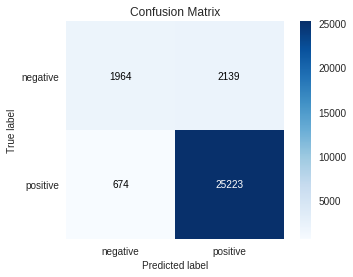

In [51]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=25,penalty='l2')
lr.fit(avgw2v_X_train,Y_train)
pred = lr.predict(avgw2v_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

In [85]:
LogisticRwithL2(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,27) #randomized cv

 accuracy with C = 27  is  91.09
F1 score with C = 27  is  77.47
Recall with C = 27  is  73.59
Precision with C = 27  is  84.08

 Classification report  with C = 27  is 
               precision    recall  f1-score   support

   negative       0.76      0.50      0.60      3831
   positive       0.93      0.98      0.95     24704

avg / total       0.90      0.91      0.90     28535

no. of non zero elements = 50


**CONFUSION MATRIX WITH RANDOMIZED CV**

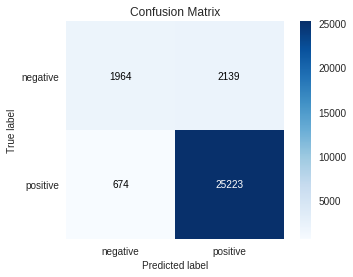

In [59]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=25,penalty='l2')
lr.fit(avgw2v_X_train,Y_train)
pred = lr.predict(avgw2v_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# Logistic Regression with L1 regularizer

In [39]:
LogisticRwithL1(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,25)

 accuracy with C = 25  is  90.62
F1 score with C = 25  is  76.48
Recall with C = 25  is  72.62
Precision with C = 25  is  83.3

 Classification report  with C = 25  is 
               precision    recall  f1-score   support

   negative       0.74      0.48      0.58      4103
   positive       0.92      0.97      0.95     25897

avg / total       0.90      0.91      0.90     30000

no. of non zero elements = 50


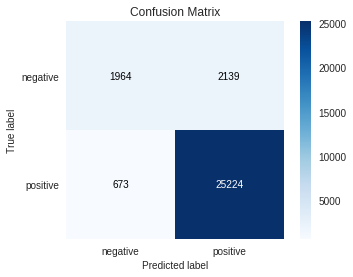

In [60]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
lr = LogisticRegression(C=25,penalty='l1')
lr.fit(avgw2v_X_train,Y_train)
pred = lr.predict(avgw2v_X_test)
skplt.plot_confusion_matrix(Y_test , pred)

# Sparcity check with L1 regularizer

In [40]:
LogisticRwithL1(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,25)

 accuracy with C = 25  is  90.62
F1 score with C = 25  is  76.48
Recall with C = 25  is  72.62
Precision with C = 25  is  83.3

 Classification report  with C = 25  is 
               precision    recall  f1-score   support

   negative       0.74      0.48      0.58      4103
   positive       0.92      0.97      0.95     25897

avg / total       0.90      0.91      0.90     30000

no. of non zero elements = 50


In [41]:
LogisticRwithL1(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,20)

 accuracy with C = 20  is  90.62
F1 score with C = 20  is  76.49
Recall with C = 20  is  72.63
Precision with C = 20  is  83.32

 Classification report  with C = 20  is 
               precision    recall  f1-score   support

   negative       0.74      0.48      0.58      4103
   positive       0.92      0.97      0.95     25897

avg / total       0.90      0.91      0.90     30000

no. of non zero elements = 50


In [45]:
LogisticRwithL1(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,15)

 accuracy with C = 15  is  90.62
F1 score with C = 15  is  76.48
Recall with C = 15  is  72.62
Precision with C = 15  is  83.31

 Classification report  with C = 15  is 
               precision    recall  f1-score   support

   negative       0.74      0.48      0.58      4103
   positive       0.92      0.97      0.95     25897

avg / total       0.90      0.91      0.90     30000

no. of non zero elements = 50


In [46]:
LogisticRwithL1(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,10)

 accuracy with C = 10  is  90.62
F1 score with C = 10  is  76.48
Recall with C = 10  is  72.62
Precision with C = 10  is  83.3

 Classification report  with C = 10  is 
               precision    recall  f1-score   support

   negative       0.74      0.48      0.58      4103
   positive       0.92      0.97      0.95     25897

avg / total       0.90      0.91      0.90     30000

no. of non zero elements = 50


# HERE SPARCITY IS NOT INCREASING WITH DECREASE IN C

# Pertubation test

In [90]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression(C=25,penalty='l2')
lr.fit(avgw2v_X_train,Y_train)
print('*********************************')

print(lr.coef_[0])
weights= lr.coef_[0]
weights = weights[0:50]
print(weights)
print("No. of non zero elements",np.count_nonzero(lr.coef_[0]))
print('*********************************')

from scipy.sparse import find
avgw2v_X_trainE=avgw2v_X_train
epsilon = np.random.uniform(low=0.0,high=0.01,size=(find(avgw2v_X_trainE)[0].size))
a,b,c=find(avgw2v_X_trainE)
avgw2v_X_trainE[a,b] = epsilon + avgw2v_X_trainE[a,b]
print('*********************************')

from sklearn.linear_model import LogisticRegression
lr1 =  LogisticRegression(C=27,penalty='l2')
lr1.fit(avgw2v_X_trainE,Y_train)
print('*********************************')

weights2=lr1.coef_[0]
weights2=weights2[:50]
print('*********************************')

difference = (abs(weights - weights2)/weights)*100
print('*********************************')

print(difference[np.where(difference >30)].size)

*********************************
[-3.15821472  1.68196473 -0.80085026  1.36911819 -0.44368107  4.08261272
  0.11932175 -3.48488092 -0.9176814   0.27768966  1.22114916  6.10302294
 -4.19876017  2.35996753 -0.69217824 -6.38677786  0.36908038 -2.01858341
  4.75357155  1.81491603  2.63599331 -2.07727835 -2.29859282  2.65546454
 -2.51622812 -1.49070893 -1.11780679  2.74149423 -0.5662449   0.36891856
  0.97376299  1.11416038  2.43325833 -3.77795646 -0.5062483  -3.59682799
  3.60089902  0.62214575  0.81438875 -0.35978199  5.73067873  3.34184676
 -1.44542968  1.25927739  3.92521413 -0.11752833 -0.35857178 -0.30266504
  2.96480094 -5.43876429]
[-3.15821472  1.68196473 -0.80085026  1.36911819 -0.44368107  4.08261272
  0.11932175 -3.48488092 -0.9176814   0.27768966  1.22114916  6.10302294
 -4.19876017  2.35996753 -0.69217824 -6.38677786  0.36908038 -2.01858341
  4.75357155  1.81491603  2.63599331 -2.07727835 -2.29859282  2.65546454
 -2.51622812 -1.49070893 -1.11780679  2.74149423 -0.5662449   0.


## There is no sighn of multicollinearity



# tfidf - w2v

# HERE WE WILL TAKE ONLY 10K  POINTS BECAUSE OF TIME ISSUE

In [0]:
i=0
str1=''
list_of_sent=[]
final_string_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (words.lower() not in stop)):    
                filtered_sentence.append(words.lower())
                str1 += " "+words.lower() 
            else:
                continue
   
    list_of_sent.append(filtered_sentence)
    final_string_tfidf.append((str1).strip())

In [0]:
final['NONSTEMDATA'] = list_of_sent

In [0]:
final_score=final['Score'].values[0:10000]

In [27]:
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,NONSTEMDATA
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,"[witty, little, book, makes, son, laugh, loud,..."
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,"[remember, seeing, show, aired, television, ye..."
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,"[beetlejuice, well, written, movie, everything..."
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,"[twist, rumplestiskin, captured, film, starrin..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,"[beetlejuice, excellent, funny, movie, keaton,..."
5,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09 00:00:00,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...,"[one, movie, movie, collection, filled, comedy..."
6,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19 00:00:00,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...,"[always, enjoyed, movie, funny, entertaining, ..."
7,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24 00:00:00,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...,"[bought, apartment, infested, fruit, flies, ho..."
8,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26 00:00:00,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...,"[happens, say, name, three, times, michael, ke..."
9,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03 00:00:00,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...,"[im, getting, crazy, im, looking, beatlejuice,..."


In [69]:
final['Text'].values[0:1]

array(["this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college"],
      dtype=object)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf_sample=final_string_tfidf[0:10000]
final_tfidf_sent = tfidf_vect.fit_transform(final_tfidf_sample)


In [0]:
from gensim.models import KeyedVectors
from gensim.models import KeyedVectors

w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
features = tfidf_vect.get_feature_names()
w2v_words=list(w2v_model.wv.vocab)
row=0

tfidf_sent_vectors = []; 
for sent in list_of_sent[0:10000]:
    weight_sum =0;

    sent_vec = np.zeros(50) 
    for word in sent:
        if ((word in w2v_words) and (word in features)):
            vec = w2v_model.wv[word]
            
            tf_idf =final_tfidf_sent[row ,features.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec) 
    row += 1

In [0]:
tfidf_sent_vectors =np.array(tfidf_sent_vectors)

In [33]:
tfidf_sent_vectors

array([[-0.74585898, -0.17011142, -0.2524059 , ..., -0.58171347,
         0.01811575, -0.02361078],
       [-0.86884607, -0.50484847,  0.03927412, ..., -1.03084286,
        -0.27437974,  0.07811461],
       [-0.42516225,  0.46613403, -0.17591183, ..., -1.08507517,
         1.22869167, -0.18830133],
       ...,
       [-0.29927134,  2.17011415,  0.63708749, ...,  0.86018123,
        -1.12709263, -0.74605387],
       [ 0.26359387,  1.84206938,  0.03616659, ...,  0.75132746,
        -0.11150809, -1.10461932],
       [ 0.05884532,  1.53456036,  1.35095256, ...,  1.57463049,
        -0.14038508, -0.93378691]])

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(tfidf_sent_vectors,final_score,test_size=0.3,shuffle=False)

In [0]:
from sklearn import preprocessing
tfidf_w2v_X_train= preprocessing.normalize(X_train)
tfidf_w2v_X_test = preprocessing.normalize(X_test)

In [37]:
tfidf_w2v_X_train.shape

(7000, 50)

# GRID SEARCH CV

In [38]:
bestHyperparameter = bestLambda(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   21.2s finished


In [39]:
print("BEST HYPERPARAMETER WITH GRID SEARCH CV IS",bestHyperparameter)

BEST HYPERPARAMETER WITH GRID SEARCH CV IS {'C': 3, 'penalty': 'l2'}


# Random SEARCH CV

In [40]:
bestHyperparameterR = bestLambdaR(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.6s finished


In [41]:
print("BEST HYPERPARAMETER WITH Random SEARCH CV IS",bestHyperparameter)

BEST HYPERPARAMETER WITH Random SEARCH CV IS {'C': 3, 'penalty': 'l2'}


# LOGISTIC REGRESSION WITH L2 regularizer

In [43]:
LogisticRwithL2(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test,3)

 accuracy with C = 3  is  92.03
F1 score with C = 3  is  73.09
Recall with C = 3  is  68.22
Precision with C = 3  is  84.37

 Classification report  with C = 3  is 
               precision    recall  f1-score   support

   negative       0.76      0.38      0.51       322
   positive       0.93      0.99      0.96      2678

avg / total       0.91      0.92      0.91      3000

no. of non zero elements = 50


# LOGISTIC REGRESSION WITH L1 regularizer



In [44]:
LogisticRwithL1(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test,3)

 accuracy with C = 3  is  91.93
F1 score with C = 3  is  73.11
Recall with C = 3  is  68.43
Precision with C = 3  is  83.41

 Classification report  with C = 3  is 
               precision    recall  f1-score   support

   negative       0.74      0.39      0.51       322
   positive       0.93      0.98      0.96      2678

avg / total       0.91      0.92      0.91      3000

no. of non zero elements = 46


# SPARCITY CHECK WITH DECREASE IN C

In [51]:
LogisticRwithL1(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test,15)

 accuracy with C = 15  is  92.03
F1 score with C = 15  is  73.59
Recall with C = 15  is  68.9
Precision with C = 15  is  83.69

 Classification report  with C = 15  is 
               precision    recall  f1-score   support

   negative       0.74      0.39      0.52       322
   positive       0.93      0.98      0.96      2678

avg / total       0.91      0.92      0.91      3000

no. of non zero elements = 49


In [52]:
LogisticRwithL1(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test,10)

 accuracy with C = 10  is  92.0
F1 score with C = 10  is  73.43
Recall with C = 10  is  68.74
Precision with C = 10  is  83.6

 Classification report  with C = 10  is 
               precision    recall  f1-score   support

   negative       0.74      0.39      0.51       322
   positive       0.93      0.98      0.96      2678

avg / total       0.91      0.92      0.91      3000

no. of non zero elements = 48


In [53]:
LogisticRwithL1(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test,5)

 accuracy with C = 5  is  91.97
F1 score with C = 5  is  73.27
Recall with C = 5  is  68.59
Precision with C = 5  is  83.5

 Classification report  with C = 5  is 
               precision    recall  f1-score   support

   negative       0.74      0.39      0.51       322
   positive       0.93      0.98      0.96      2678

avg / total       0.91      0.92      0.91      3000

no. of non zero elements = 46


# AS YOU CAN SEE THAT WITH DECREASE IN C ,SPARCITY IS INCREASING

# PERTUBATION TEST

In [63]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression(C=3,penalty='l2')
lr.fit(tfidf_w2v_X_train,Y_train)
print('*********************************')

print(lr.coef_[0])
weights= lr.coef_[0]
weights = weights[0:50]
print(weights)
print("No. of non zero elements",np.count_nonzero(lr.coef_[0]))
print('*********************************')

from scipy.sparse import find
tfidf_w2v_X_trainE = tfidf_w2v_X_train
epsilon = np.random.uniform(low=0.0,high=0.01,size=(find(tfidf_w2v_X_trainE)[0].size))
a,b,c=find(tfidf_w2v_X_train)
tfidf_w2v_X_trainE[a,b] = epsilon + tfidf_w2v_X_trainE[a,b]
print('*********************************')

from sklearn.linear_model import LogisticRegression
lr1 =  LogisticRegression(C=27,penalty='l2')
lr1.fit(tfidf_w2v_X_trainE,Y_train)
print('*********************************')

weights2=lr1.coef_[0]
weights2=weights2[:50]
print('*********************************')

difference = (abs(weights - weights2)/weights)*100
print('*********************************')

print(difference[np.where(difference >30)].size)

*********************************
[-2.27618422  1.57265171 -1.39025384  0.95291766  0.28913755  3.07552392
 -0.77270053 -2.63494492 -0.5345029  -0.6022193   1.77390796  2.48785043
 -3.56442401  1.91186116 -0.10728409 -5.12963009  0.97718958 -1.90992516
  2.64287064  0.49231273  2.97571883 -2.10782559 -1.64429481  2.62885937
 -1.68586137 -1.60632283 -0.09692658  1.8622881  -0.46768575  1.13516915
  0.89824821  0.63186167  3.0092558  -3.18111764 -0.75845429 -2.85533663
  3.98341613 -0.14450428  1.05981456 -1.26827113  4.69777116  1.00799074
 -0.89297664  1.10592854  1.33877832  0.04408528 -0.53538392 -1.06590311
  1.77034341 -3.0148527 ]
[-2.27618422  1.57265171 -1.39025384  0.95291766  0.28913755  3.07552392
 -0.77270053 -2.63494492 -0.5345029  -0.6022193   1.77390796  2.48785043
 -3.56442401  1.91186116 -0.10728409 -5.12963009  0.97718958 -1.90992516
  2.64287064  0.49231273  2.97571883 -2.10782559 -1.64429481  2.62885937
 -1.68586137 -1.60632283 -0.09692658  1.8622881  -0.46768575  1.

# AS there are only 2 features that are changing with more than 30% therefore there in no multicollinearity

# final conclusion

![alt text](https://)

In [0]:
from google.colab import files
from IPython.display import Image

In [126]:
uploaded = files.upload()



Saving Screenshot (5745).png to Screenshot (5745) (1).png


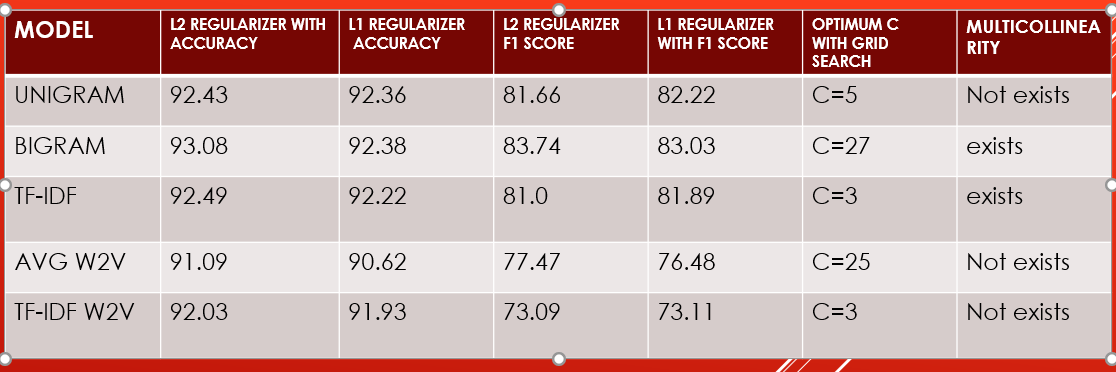

In [128]:
Image("Screenshot (5745).png", width=1000)

